### Loading necessary libraries

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image
import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

import joblib

### Defining files' path

In [4]:
data_dir = 'C:\\Users\\jocl0\\Project1\\data\\'
model_dir = 'C:\\Users\\jocl0\\Project1\\model\\'

dir_ = os.listdir(data_dir)

model_file = model_dir + 'CNN_aug_wonder.joblib'

In [5]:
dir_

['images2predict', 'test', 'train', 'valid']

### Retrieving directories list

In [7]:
all_dir = dict.fromkeys(dir_)

for d in dir_ :
    all_dir[d] = glob.glob(data_dir+d+'/*')

### Retrieving data files

In [130]:
files = dict.fromkeys(dir_)

for key in dict.fromkeys(dir_) :
    files[key] = []

    if key != 'images2predict' :
        for d in range(len(all_dir[key])) :
            files[key].extend(glob.glob(all_dir[key][d]+'/*.jpg'))
    else :
        files[key].extend(glob.glob(data_dir+'images2predict'+'/dum'+'/*.jpg'))

### Investigate dataset resolution distribution

In [11]:
for key in dict.fromkeys(dir_) :
    # Empty shape list
    shape = []

    # Empty image list
    image_un = []

    for file in files[key] :
        # Read image file
        image = plt.imread(file)

        # Add image to image list
        image_un.append(image)

        shape.append(image.shape)

    # Sum the shape
    shape_sum = tuple(map(sum, tuple(zip(*shape)))) 
    shape_median = tuple(np.percentile(dim, 50) for dim in zip(*shape))
    shape_per25 = tuple(np.percentile(dim, 25) for dim in zip(*shape))
    shape_per75 = tuple(np.percentile(dim, 75) for dim in zip(*shape))
    shape_per90 = tuple(np.percentile(dim, 90) for dim in zip(*shape))
    shape_min = tuple(map(min, tuple(zip(*shape))))
    shape_max = tuple(map(max, tuple(zip(*shape))))

    # Calcualting shape average
    shape_avg = tuple( i // len(shape) for i in shape_sum)

    # Print results
    print(f'The average dimensions for images in the {key} folder is {shape_avg}')
    print(f'The maximum dimensions for images in the {key} folder is {shape_max}')
    print(f'The mimimum dimensions for images in the {key} folder is {shape_min}')
    print(f'The median dimensions for images in the {key} folder is {shape_median}')
    print(f'The 25th percentile dimensions for images in the {key} folder is {shape_per25}')
    print(f'The 75th percentile dimensions for images in the {key} folder is {shape_per75}')
    print(f'The 90th percentile dimensions for images in the {key} folder is {shape_per90}\n\n')

The average dimensions for images in the images2predict folder is ()
The maximum dimensions for images in the images2predict folder is ()
The mimimum dimensions for images in the images2predict folder is ()
The median dimensions for images in the images2predict folder is ()
The 25th percentile dimensions for images in the images2predict folder is ()
The 75th percentile dimensions for images in the images2predict folder is ()
The 90th percentile dimensions for images in the images2predict folder is ()


The average dimensions for images in the test folder is (224, 224, 3)
The maximum dimensions for images in the test folder is (224, 224, 3)
The mimimum dimensions for images in the test folder is (224, 224, 3)
The median dimensions for images in the test folder is (224.0, 224.0, 3.0)
The 25th percentile dimensions for images in the test folder is (224.0, 224.0, 3.0)
The 75th percentile dimensions for images in the test folder is (224.0, 224.0, 3.0)
The 90th percentile dimensions for imag

### Defining the image resolution

In [13]:
res = (224, 224)

### Image Augmentation and Scaling

In [15]:
img_gen = ImageDataGenerator(rescale=1./255)

img_gen_train = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True,
                                   zoom_range=0.1, 
                                   brightness_range=[0.8,1.2],  
                                   fill_mode='nearest')


### Apply Image augmentation and scaling to dataset

In [17]:
train_data = img_gen_train.flow_from_directory(data_dir+'train',
                                               target_size=res, 
                                               batch_size=32, 
                                               class_mode='categorical',
                                               shuffle=True)

train_data.class_indices

Found 3208 images belonging to 20 classes.


{'ABBOTTS BABBLER': 0,
 'ABBOTTS BOOBY': 1,
 'ABYSSINIAN GROUND HORNBILL': 2,
 'AFRICAN CROWNED CRANE': 3,
 'AFRICAN EMERALD CUCKOO': 4,
 'AFRICAN FIREFINCH': 5,
 'AFRICAN OYSTER CATCHER': 6,
 'AFRICAN PIED HORNBILL': 7,
 'AFRICAN PYGMY GOOSE': 8,
 'ALBATROSS': 9,
 'ALBERTS TOWHEE': 10,
 'ALEXANDRINE PARAKEET': 11,
 'ALPINE CHOUGH': 12,
 'ALTAMIRA YELLOWTHROAT': 13,
 'AMERICAN AVOCET': 14,
 'AMERICAN BITTERN': 15,
 'AMERICAN COOT': 16,
 'AMERICAN FLAMINGO': 17,
 'AMERICAN GOLDFINCH': 18,
 'AMERICAN KESTREL': 19}

In [18]:
val_data = img_gen.flow_from_directory(data_dir+'test',
                                       target_size=res, 
                                       batch_size=1, 
                                       shuffle=False,
                                       class_mode='categorical')

val_data.class_indices

Found 100 images belonging to 20 classes.


{'ABBOTTS BABBLER': 0,
 'ABBOTTS BOOBY': 1,
 'ABYSSINIAN GROUND HORNBILL': 2,
 'AFRICAN CROWNED CRANE': 3,
 'AFRICAN EMERALD CUCKOO': 4,
 'AFRICAN FIREFINCH': 5,
 'AFRICAN OYSTER CATCHER': 6,
 'AFRICAN PIED HORNBILL': 7,
 'AFRICAN PYGMY GOOSE': 8,
 'ALBATROSS': 9,
 'ALBERTS TOWHEE': 10,
 'ALEXANDRINE PARAKEET': 11,
 'ALPINE CHOUGH': 12,
 'ALTAMIRA YELLOWTHROAT': 13,
 'AMERICAN AVOCET': 14,
 'AMERICAN BITTERN': 15,
 'AMERICAN COOT': 16,
 'AMERICAN FLAMINGO': 17,
 'AMERICAN GOLDFINCH': 18,
 'AMERICAN KESTREL': 19}

In [19]:
test_data = img_gen.flow_from_directory(data_dir+'valid',
                                       target_size=res, 
                                       batch_size=1, 
                                       shuffle=False,
                                       class_mode='categorical')

test_data.class_indices

Found 100 images belonging to 20 classes.


{'ABBOTTS BABBLER': 0,
 'ABBOTTS BOOBY': 1,
 'ABYSSINIAN GROUND HORNBILL': 2,
 'AFRICAN CROWNED CRANE': 3,
 'AFRICAN EMERALD CUCKOO': 4,
 'AFRICAN FIREFINCH': 5,
 'AFRICAN OYSTER CATCHER': 6,
 'AFRICAN PIED HORNBILL': 7,
 'AFRICAN PYGMY GOOSE': 8,
 'ALBATROSS': 9,
 'ALBERTS TOWHEE': 10,
 'ALEXANDRINE PARAKEET': 11,
 'ALPINE CHOUGH': 12,
 'ALTAMIRA YELLOWTHROAT': 13,
 'AMERICAN AVOCET': 14,
 'AMERICAN BITTERN': 15,
 'AMERICAN COOT': 16,
 'AMERICAN FLAMINGO': 17,
 'AMERICAN GOLDFINCH': 18,
 'AMERICAN KESTREL': 19}

In [20]:
pred_data = img_gen.flow_from_directory(data_dir+'images2predict',
                                       target_size=res, 
                                       batch_size=1, 
                                       shuffle=False,
                                       class_mode=None)

pred_data.class_indices

Found 6 images belonging to 1 classes.


{'dum': 0}

### Load model if it already exists

In [62]:
if os.path.exists(model_file) :
    cnn_ = load_model("C:\\Users\\jocl0\\Project1\\model\\CNN_aug_wonder.keras")
    print('Model exists')

Model exists


### Define model if it does not already exist

In [43]:
if not os.path.exists(model_file) :
    print('Model does not exists')

    cnn = Sequential()
    
    cnn.add(Conv2D(filters=8,kernel_size=(10,10), padding='valid', activation='relu' ,input_shape=(res[0],res[1],3)))

    cnn.add(Conv2D(filters=16,kernel_size=(7,7), padding='same', activation='relu'))

    cnn.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))
    cnn.add(MaxPool2D(pool_size=(2,2)))
    
    cnn.add(Conv2D(filters=64, kernel_size=(3,3),  padding='same', activation='relu'))
    cnn.add(MaxPool2D(pool_size=(2,2)))

    cnn.add(Conv2D(filters=128, kernel_size=(3,3), strides=2, padding='same', activation='relu'))
    cnn.add(MaxPool2D(pool_size=(2,2))) 

    cnn.add(Conv2D(filters=128, kernel_size=(3,3), strides=2, activation='relu',  padding='same'))
    cnn.add(MaxPool2D(pool_size=(2,2)))

    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))

    cnn.add(Dropout(rate= 0.3)) 

    cnn.add(Dense(units=len(train_data.class_indices), activation='softmax'))

    cnn.compile(optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'],loss='categorical_crossentropy') 
    

Model does not exists


### Print model summary

In [45]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 215, 215, 8)       2408      
                                                                 
 conv2d_1 (Conv2D)           (None, 215, 215, 16)      6288      
                                                                 
 conv2d_2 (Conv2D)           (None, 215, 215, 32)      12832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 107, 107, 32)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                    

### Train the model on the dataset

In [57]:
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn.fit(train_data, epochs=100, validation_data=test_data, callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
101/101 [==============================] - 217s 2s/step - loss: 1.0632 - accuracy: 0.6605 - val_loss: 0.8120 - val_accuracy: 0.7400 - lr: 1.0000e-04
Epoch 2/100
101/101 [==============================] - 183s 2s/step - loss: 1.0603 - accuracy: 0.6633 - val_loss: 0.7757 - val_accuracy: 0.7800 - lr: 1.0000e-04
Epoch 3/100
101/101 [==============================] - 192s 2s/step - loss: 1.0240 - accuracy: 0.6802 - val_loss: 0.7418 - val_accuracy: 0.7800 - lr: 1.0000e-04
Epoch 4/100
101/101 [==============================] - 179s 2s/step - loss: 1.0060 - accuracy: 0.6873 - val_loss: 0.7635 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 5/100
101/101 [==============================] - 178s 2s/step - loss: 0.9982 - accuracy: 0.6830 - val_loss: 0.6989 - val_accuracy: 0.8100 - lr: 1.0000e-04
Epoch 6/100
101/101 [==============================] - 187s 2s/step - loss: 1.0113 - accuracy: 0.6783 - val_loss: 0.7123 - val_accuracy: 0.7700 - lr: 1.0000e-04
Epoch 7/100
101/101 [=============

### Save model

In [60]:
#joblib.dump(cnn, "C:\\Users\\jocl0\\Project1\\model\\CNN_aug_wonder.joblib")
cnn.save("C:\\Users\\jocl0\\Project1\\model\\CNN_aug_wonder.keras")
#joblib.dump(img_gen_train, "C:\\Users\\jocl0\\Project1\\model\\CNN_img_gen_train_aug_wonder.joblib")

### Viusalize metrics

In [64]:
metrics = pd.DataFrame(cnn.history.history, index=list(range(1,len(cnn.history.history['accuracy'])+1)))
metrics

,loss,accuracy,val_loss,val_accuracy,lr
1,1.063157,0.660536,0.811989,0.74,0.0001
2,1.060338,0.663342,0.775655,0.78,0.0001
3,1.023981,0.680175,0.741770,0.78,0.0001
4,1.005982,0.687344,0.763511,0.75,0.0001
5,0.998165,0.682980,0.698908,0.81,0.0001
6,1.011319,0.678304,0.712343,0.77,0.0001
7,0.988868,0.698566,0.744419,0.79,0.0001
8,0.968506,0.688591,0.732127,0.77,0.0001
9,0.995077,0.677993,0.708298,0.76,0.0001
10,0.981611,0.685162,0.680768,0.83,0.0001


<Axes: >

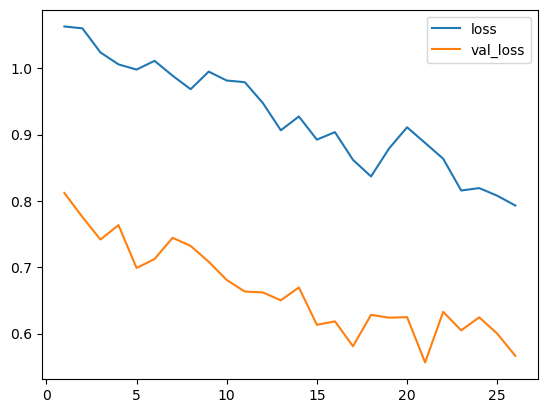

In [66]:
metrics[['loss','val_loss']].plot()

<Axes: >

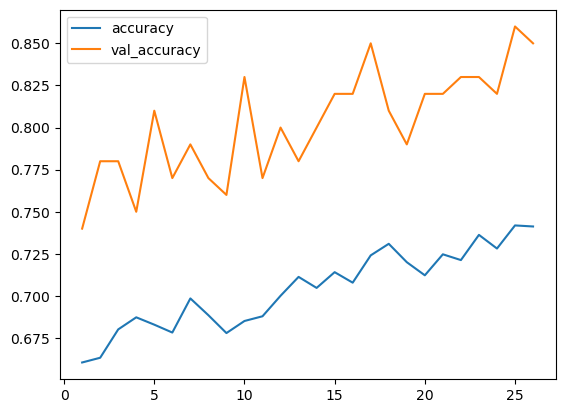

In [68]:
metrics[['accuracy','val_accuracy']].plot()

### Model's performance on validation data

In [78]:
y_pred_val = cnn.predict(val_data)

100/100 [==============================] - 2s 24ms/step


In [80]:
y_true_val = []

for i in range(len(val_data)):
    y_true_val.extend(np.argmax(val_data[i][1], axis=1))

y_true_val = np.array(y_true_val)

In [82]:
# Convert predictions to class labels
y_pred_val_classes = np.argmax(y_pred_val, axis=1)

In [84]:
print(classification_report(y_true_val, y_pred_val_classes, 
                            target_names=val_data.class_indices.keys()))

                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.71      1.00      0.83         5
             ABBOTTS BOOBY       0.75      0.60      0.67         5
ABYSSINIAN GROUND HORNBILL       1.00      0.80      0.89         5
     AFRICAN CROWNED CRANE       0.83      1.00      0.91         5
    AFRICAN EMERALD CUCKOO       0.80      0.80      0.80         5
         AFRICAN FIREFINCH       1.00      0.80      0.89         5
    AFRICAN OYSTER CATCHER       0.83      1.00      0.91         5
     AFRICAN PIED HORNBILL       0.83      1.00      0.91         5
       AFRICAN PYGMY GOOSE       0.83      1.00      0.91         5
                 ALBATROSS       0.75      0.60      0.67         5
            ALBERTS TOWHEE       0.83      1.00      0.91         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
             ALPINE CHOUGH       0.57      0.80      0.67         5
     ALTAMIRA YELLOWTHROAT       1.00      1.00

### Model's performance on test data

In [87]:
y_pred = cnn.predict(test_data)

100/100 [==============================] - 2s 19ms/step


In [89]:
y_true = []

for i in range(len(test_data)):
    y_true.extend(np.argmax(test_data[i][1], axis=1))

y_true = np.array(y_true)

In [91]:
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

In [93]:
print(classification_report(y_true, y_pred_classes, 
                            target_names=test_data.class_indices.keys()))

                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.67      0.80      0.73         5
             ABBOTTS BOOBY       0.50      0.60      0.55         5
ABYSSINIAN GROUND HORNBILL       0.83      1.00      0.91         5
     AFRICAN CROWNED CRANE       1.00      0.80      0.89         5
    AFRICAN EMERALD CUCKOO       1.00      0.60      0.75         5
         AFRICAN FIREFINCH       1.00      1.00      1.00         5
    AFRICAN OYSTER CATCHER       0.80      0.80      0.80         5
     AFRICAN PIED HORNBILL       0.71      1.00      0.83         5
       AFRICAN PYGMY GOOSE       0.83      1.00      0.91         5
                 ALBATROSS       0.75      0.60      0.67         5
            ALBERTS TOWHEE       0.50      0.60      0.55         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
             ALPINE CHOUGH       0.83      1.00      0.91         5
     ALTAMIRA YELLOWTHROAT       0.80      0.80

### Making a prediction on new dataset

In [97]:
y_pred_new = cnn.predict(pred_data)

6/6 [==============================] - 0s 22ms/step


In [99]:
# Convert predictions to class labels
y_pred_new_classes = np.argmax(y_pred_new, axis=1)
y_pred_new_classes

array([3, 3, 3, 3, 3, 1], dtype=int64)

In [101]:
# Convert classes to keys
train_labels = list(train_data.class_indices.keys())

y_pred_new_classes_labels = list(map(lambda x: train_labels[x], y_pred_new_classes))
y_pred_new_classes_labels

['AFRICAN CROWNED CRANE',
 'AFRICAN CROWNED CRANE',
 'AFRICAN CROWNED CRANE',
 'AFRICAN CROWNED CRANE',
 'AFRICAN CROWNED CRANE',
 'ABBOTTS BOOBY']

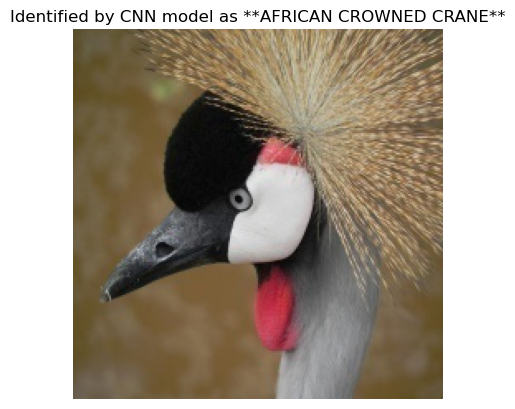

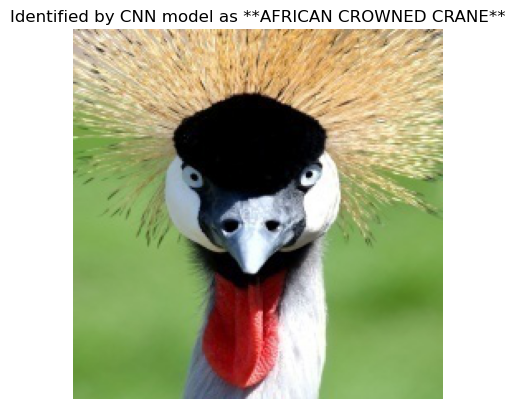

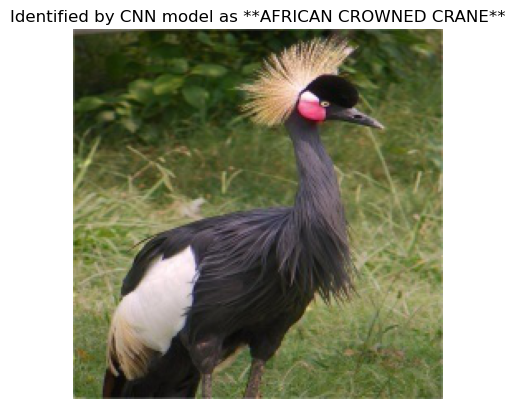

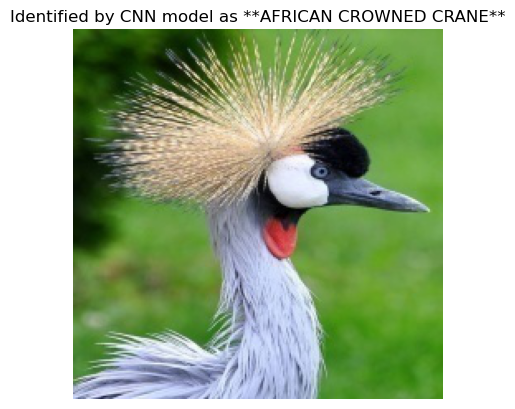

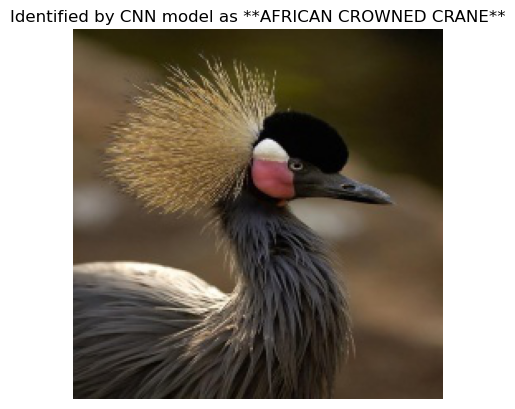

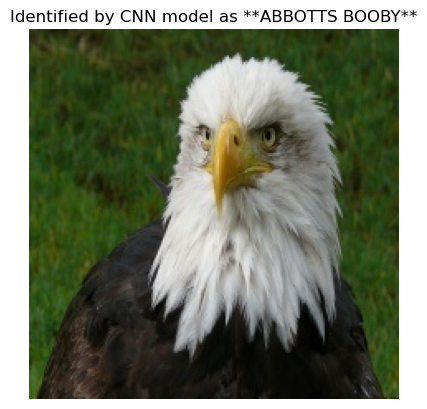

In [140]:
for idx, file in enumerate(files['images2predict']) :
    image = plt.imread(file) 
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Identified by CNN model as **{y_pred_new_classes_labels[idx]}**')
    plt.savefig(f'C:\\Users\\jocl0\\Project1\\images\\pred_w_CNN_{idx+1}')
    plt.show()